In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )
        self.action_bound = action_bound
    
    def forward(self, state):
        return self.net(state) * self.action_bound

class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

In [4]:
class DDPG:
    """ DDPG Algorithm """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 action_bound,
                 sigma,
                 actor_lr,
                 critic_lr,
                 tau,
                 gamma,
                 device):
        
        self.gamma = gamma
        self.sigma = sigma # std of Gaussian noise, the mean is 0
        self.tau = tau # soft update parameter of target network
        self.action_dim = action_dim
        self.device = device
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param, param_target in zip(net.parameters(), target_net.parameters()):
            param_target.data.copy_(self.tau * param.data + (1.0 - self.tau) * param_target.data)
    
    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (~dones.bool()).float()
        critic_loss = F.mse_loss(self.critic(states, actions), q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)

In [8]:
actor_lr = 1e-3 
critic_lr = 1e-2
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DDPG(state_dim,
             hidden_dim,
             action_dim,
             action_bound,
             sigma,
             actor_lr,
             critic_lr,
             tau,
             gamma,
             device)

In [9]:
return_list = rl_utils.train_off_policy_agent(env,
                                              agent,
                                              num_episodes,
                                              replay_buffer,
                                              minimal_size,
                                              batch_size)

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s, episode=200, return=-156.325]


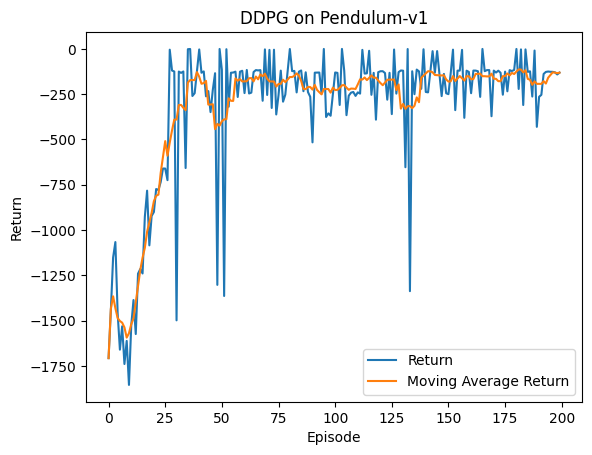

In [10]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('DDPG on {}'.format(env_name))
plt.show()

In [11]:
rl_utils.watch_agent(env_name, agent, device, num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [12]:
score = rl_utils.moving_average_score(return_list)
print(score)

-156.32471084579862


In [13]:
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='ddpg_pendulum(v1)-r1',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='ddpg_pendulum(v1)-r2',
                                  score=score)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building file ./video/ddpg_pendulum(v1)-r1_score-156.32_20250502-021744.gif with imageio.


✅ Video saved at ./video/ddpg_pendulum(v1)-r1_score-156.32_20250502-021744.gif
MoviePy - Building file ./video/ddpg_pendulum(v1)-r2_score-156.32_20250502-021748.gif with imageio.


✅ Video saved at ./video/ddpg_pendulum(v1)-r2_score-156.32_20250502-021748.gif


In [14]:
agent_dict = {
    'actor': agent.actor,
    'target_actor': agent.target_actor,
    'critic': agent.critic,
    'target_critic': agent.target_critic,
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='ddpg_pendulum(v1)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/ddpg_pendulum(v1)_score-156.32_20250502-022144.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/ddpg_pendulum(v1)_score-156.32_20250502-022144_return_list.pkl
📈 Return curve saved at ./results/ddpg_pendulum(v1)_score-156.32_20250502-022144_return_curve.png
